## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Надо:** Обучить модель классифицировать комментарии на позитивные и негативные.  

Имеется набор данных с разметкой о токсичности правок.
Значение метрики качества F1 должно быть не меньше 0.75.

## Подготовка данных

In [39]:
import pandas as pd
import numpy as np

import lightgbm as lgbm
from lightgbm import LGBMClassifier

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline

import re
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import *
from sklearn.model_selection import *

from tqdm.notebook import tqdm

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

In [2]:
nltk.download('wordnet') # проводит лемматизацию
nltk.download('omw-1.4')
nltk.download('punkt') # делит текст на список предложений
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords') # слова без смысловой нагрузки

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [6]:
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

In [7]:
df = data.copy()

Наблюдается дисбаланс классов, при обучении модель это надо учитывать.

Очистим текст от лишних символов.

In [8]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    return ' '.join(text.split())

In [9]:
df_t = df.copy()

In [10]:
df_t['clear_text'] = df['text'].apply(clear_text)

In [11]:
df_t['tok_text'] = [nltk.word_tokenize(df_t['clear_text'][i], language = 'english') \
                    for i in range(df_t['clear_text'].shape[0])]

In [12]:
df_t.head()

,Unnamed: 0,text,toxic,clear_text,tok_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my..."
1,1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,"[d, aww, he, matches, this, background, colour..."
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,"[hey, man, i, m, really, not, trying, to, edit..."
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,"[more, i, can, t, make, any, real, suggestions..."
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,"[you, sir, are, my, hero, any, chance, you, re..."


### Лемматизация

In [13]:
lemmatizer = WordNetLemmatizer()

In [14]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [15]:
def lemmafunction(text):
  lemm_text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]
  return ' '.join(lemm_text)

In [16]:
df_tl = df_t.copy()

In [17]:
tqdm.pandas()

df_tl['lemm_text'] = df_tl['tok_text'].progress_apply(lemmafunction)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [18]:
df_tl[['lemm_text', 'tok_text', 'clear_text']].head()

,lemm_text,tok_text,clear_text
0,explanation why the edits make under my userna...,"[explanation, why, the, edits, made, under, my...",explanation why the edits made under my userna...
1,d aww he match this background colour i m seem...,"[d, aww, he, matches, this, background, colour...",d aww he matches this background colour i m se...
2,hey man i m really not try to edit war it s ju...,"[hey, man, i, m, really, not, trying, to, edit...",hey man i m really not trying to edit war it s...
3,more i can t make any real suggestion on impro...,"[more, i, can, t, make, any, real, suggestions...",more i can t make any real suggestions on impr...
4,you sir be my hero any chance you remember wha...,"[you, sir, are, my, hero, any, chance, you, re...",you sir are my hero any chance you remember wh...


### Делим на признаки

In [19]:
features = df_tl['lemm_text']
target = df_tl['toxic']

In [20]:
features_train, features_test, target_train, target_test = train_test_split(features, target, \
                                                                            test_size=0.1, stratify=target)

### Векторизуем

Уберем из текстов неинформативные слова.

In [21]:
stops = set(stopwords.words('english'))

In [22]:
vectorize = TfidfVectorizer(stop_words=list(stops))

In [23]:
tf_idf = vectorize.fit(features_train)

In [24]:
tf_idf_train = tf_idf.transform(features_train)
tf_idf_test = tf_idf.transform(features_test)

In [25]:
tf_idf_train.shape

(143362, 142432)

In [26]:
target_train.shape

(143362,)

### Обучение моделей

#### **Логистическая регрессия**

In [27]:
pipeline_log = Pipeline([
    ('vectorize', vectorize),
    ('logreg', LogisticRegression(random_state=12345, solver='sag', class_weight='balanced'))
])

params_log = {'logreg__C': range(4, 15)}

model_log = GridSearchCV(pipeline_log, 
                       cv=5, 
                       param_grid=params_log,
                       n_jobs=-1,  
                       scoring='f1')

In [30]:
%%time
simplefilter("ignore", category=ConvergenceWarning)

model_log.fit(features_train, target_train)

CPU times: user 41 s, sys: 5.77 s, total: 46.8 s
Wall time: 17min 37s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorize',
                                        TfidfVectorizer(stop_words=['is',
                                                                    'himself',
                                                                    't', 'ours',
                                                                    've',
                                                                    "hadn't",
                                                                    'haven',
                                                                    'for',
                                                                    "shan't",
                                                                    'during',
                                                                    'me',
                                                                    "it's",
                                                                    'over',
                                                                    'here',
                                                                    'doesn',
                                                                    "aren't",
                                                                    'because',
                                                                    'what',
                                                                    'off',
                                                                    'themselves',
                                                                    'i',
                                                                    'where',
                                                                    'my',
                                                                    'between',
                                                                    'more',
                                                                    'few',
                                                                    'wasn',
                                                                    'can',
                                                                    'who',
                                                                    "couldn't", ...])),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=12345,
                                                           solver='sag'))]),
             n_jobs=-1, param_grid={'logreg__C': range(4, 15)}, scoring='f1')

In [31]:
print(f'Лучшие параметры логистической регрессии: {model_log.best_params_}')

Лучшие параметры логистической регрессии: {'logreg__C': 5}


In [32]:
f1_log = round(model_log.best_score_,2)
print(f'F1 логистической регрессии {f1_log}')

F1 логистической регрессии 0.75


#### **LGBMClassifier**

In [36]:
pipeline_lgbm = Pipeline([
    ('vectorize', vectorize),
    ('lgbm', lgbm.sklearn.LGBMClassifier(n_estimators=50, random_state=12345))
])

params_lgbm = {'lgbm__learning_rate': [0.3, 0.5, 0.7],
               'lgbm__max_depth': [3, 5, 7]}

model_lgbm = GridSearchCV(pipeline_lgbm, 
                          cv=5, 
                          param_grid=params_lgbm,
                          n_jobs=-1,  
                          scoring='f1')

In [37]:
%%time
model_lgbm.fit(features_train, target_train)

model_lgbm.best_params_

CPU times: user 2min 53s, sys: 6.08 s, total: 2min 59s
Wall time: 40min 28s


{'lgbm__learning_rate': 0.5, 'lgbm__max_depth': 7}

In [38]:
f1_lgbm = round(model_lgbm.best_score_,2)
print(f'F1 LGBMClassifier: {f1_lgbm}')

F1 LGBMClassifier: 0.74


### Оценка моделей

In [40]:
d = {'F1':[f1_log, f1_lgbm]}
answer = pd.DataFrame(data=d, index=['LogisticRegression','LGBMClassifier'])
answer

,F1
LogisticRegression,0.75
LGBMClassifier,0.74


Лучшее качество показала модель логистической регрессии.

### Проверка качества на тестовой выборке

In [41]:
def metrics(target, features, model):
    fpr, tpr, treshold = roc_curve(target, model.predict_proba(features)[:,1])
    roc_auc = auc(fpr, tpr)
    # строим график
    plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.show()
    print('Показатели на тестовой выборке')
    print(f'F1 = {f1_score(target, model.predict(features))}')
    print(f'roc_auc = {roc_auc_score(target, model.predict_proba(features)[:,1])}')

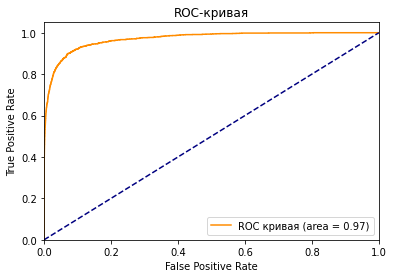

Показатели на тестовой выборке
F1 = 0.755409476855656
roc_auc = 0.9701643008490167


In [42]:
metrics(target_test, features_test, model_log)

## Вывод

Нашей задачей было обучить модель, чтобы она опрделяла токсичные комментарии для отправления их на модернизацию.  
Мы очистили текст от лишних символов, разбили его на отдельные слова, привели слова в начальную форму. Для оценки тональности текста мы использовали метод векторизации `TF_IDF`.  
Результаты моделей:
* LGBMClassifier: `F1 = 0.69`
* Логистическая регрессия: `F1 = 0.75`  

Лучшее качество показала модель логистической регрессии.  
Проверили качество на тестовой выборке и получили значение `F1 = 0.75`, значение `ROC_AUC = 0.97`. 

Для определения тональности текста рекомендуется логистическая регрессиия.